In [43]:
import numpy as np
import scipy.signal
import skimage as sk
import skimage.draw
import skimage.io as skio
from skimage.transform import rescale
from scipy.signal import *
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import json

In [214]:
def import_pairs(path):
    with open(path, 'r') as f:
        d = json.load(f)
        im1 = skio.imread(f'{d['im1_name']}.jpg')/255.
        im2 = skio.imread(f'{d['im2_name']}.jpg')/255.
        p1 = np.array(d['im1Points'] + [[0, 0], [0, im1.shape[0]], [im1.shape[1], 0], [im1.shape[1], im1.shape[0]]])
        p2 = np.array(d['im2Points'] + [[0, 0], [0, im2.shape[0]], [im2.shape[1], 0], [im2.shape[1], im2.shape[0]]])
        return p1, im1, p2, im2

cloud0, im1, cloud1, im2 = import_pairs('lduong_george_small.json')
# cloud0, im1, cloud1, im2 = import_pairs('lduong_hduong.json')
# cloud0, im1, cloud1, im2 = import_pairs('hduong_cat.json')
assert cloud0.shape == cloud1.shape
assert im1.shape == im2.shape
# print(pairs)

IndexError: invalid index to scalar variable.

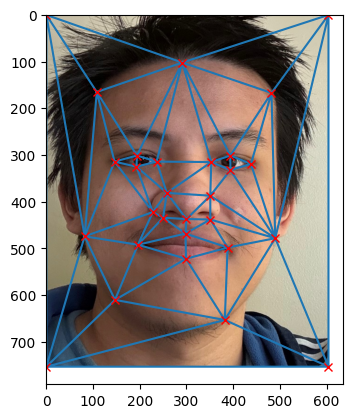

In [221]:
# f = plt.figure(figsize=(17, 20))
_Nrow = 3
_Ncol = 2

def mean_cloud(cl0, cl1):
    return (cl0 + cl1) / 2.0

def graph_tri(pts, dln):
    plt.triplot(pts[:, 0], pts[:, 1], dln.simplices)
    plt.plot(pts[:, 0], pts[:, 1], 'rx')
    for i, pt in pts:
        plt.gca().annotate(str(i), (pt[0], pt[1]))

# ax = f.add_subplot(_Nrow, _Ncol, 1)
plt.imshow(im1)
dln0 = Delaunay(cloud0)
graph_tri(cloud0, dln0)

IndexError: invalid index to scalar variable.

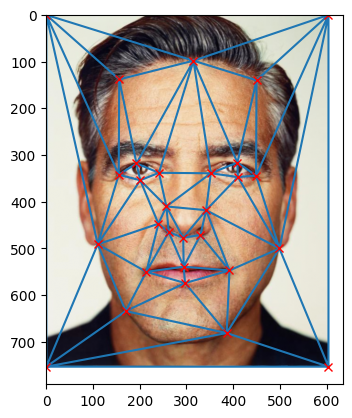

In [219]:
# ax = f.add_subplot(_Nrow, _Ncol, 2)
plt.imshow(im2)
dln1 = Delaunay(cloud1)
graph_tri(cloud1, dln1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04456182415532907..1.0254438989009758].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.010247591869857218..1.0005451829619927].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.638761740581322e-17..0.9583310460578336].


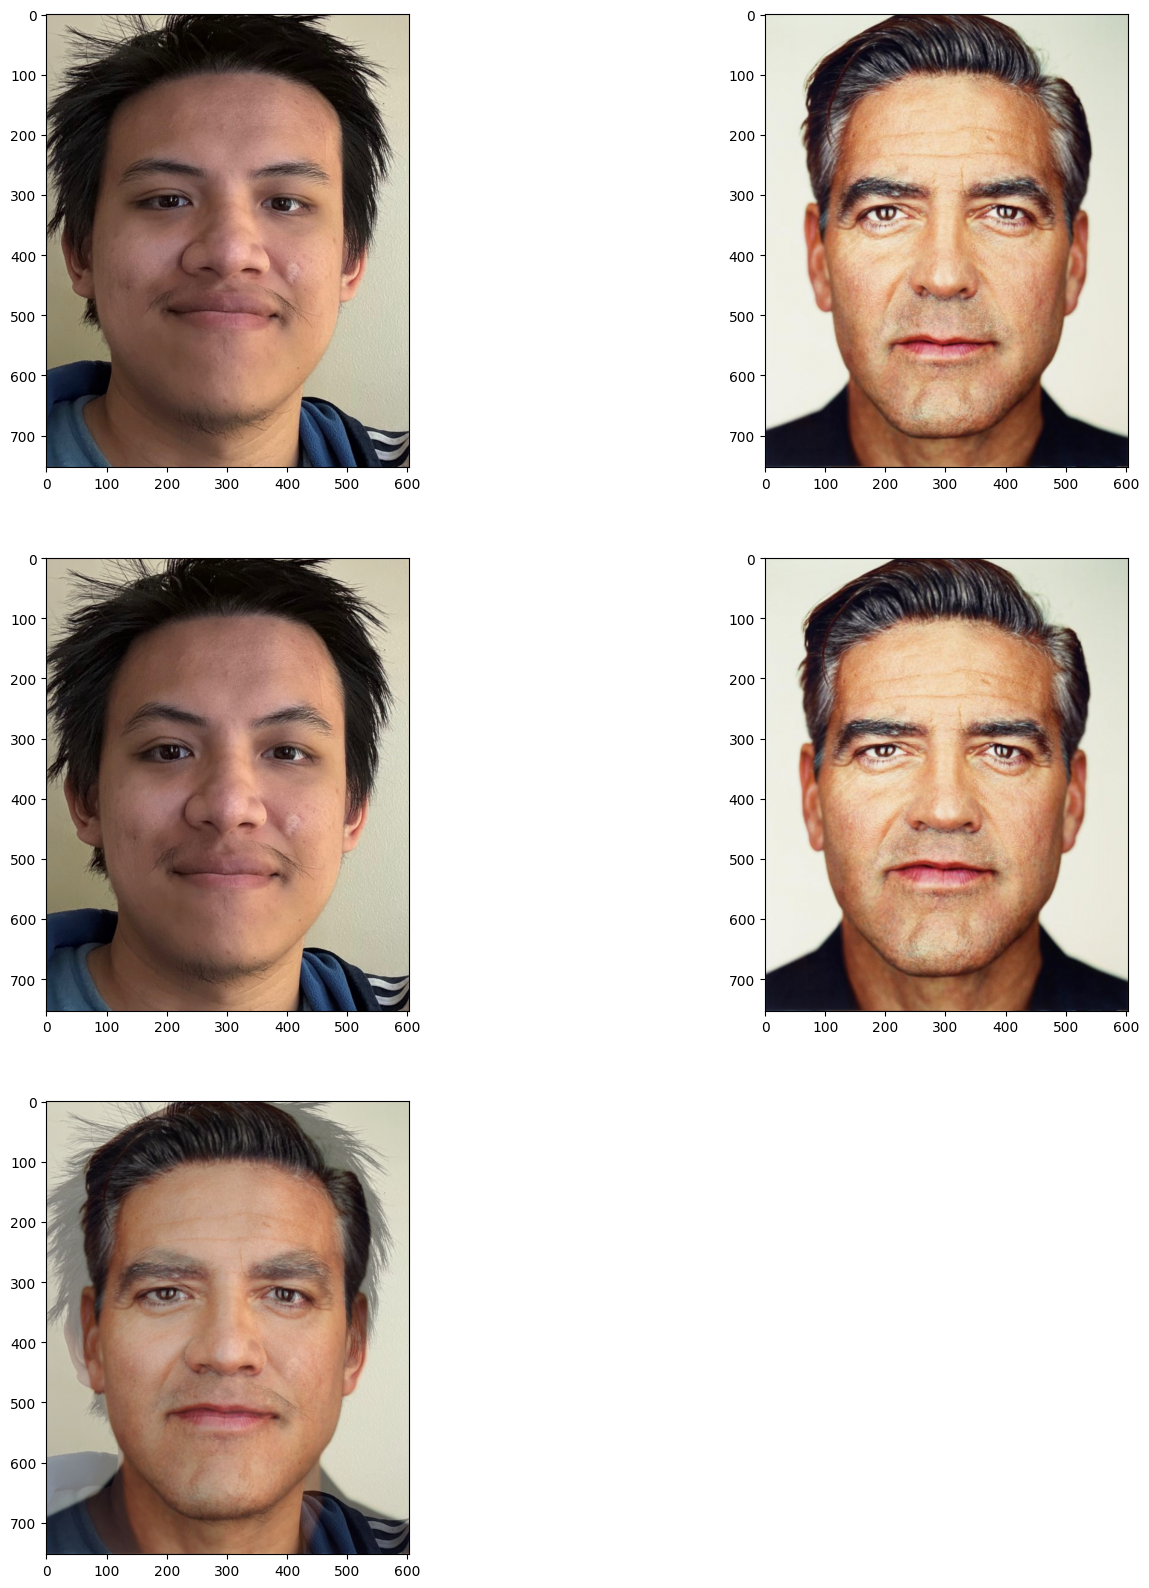

In [223]:

f = plt.figure(figsize=(17, 20))

ax = f.add_subplot(_Nrow, _Ncol, 1)
plt.imshow(im1)
ax = f.add_subplot(_Nrow, _Ncol, 2)
plt.imshow(im2)

mean = mean_cloud(cloud0, cloud1)
ax = f.add_subplot(_Nrow, _Ncol, 3)
dlnMean = Delaunay(mean)
# print(mean[dlnMean.simplices[0]])

# src_pts = cloud0[dln0.simplices[5]]
# dest_pts = mean[dlnMean.simplices[5]]
def tri_tf(src_pts, dest_pts):
    A, B, C = src_pts
    T1 = np.array([
        [C[0] - A[0], B[0] - A[0], A[0]],
        [C[1] - A[1], B[1] - A[1], A[1]],
        [0   , 0   , 1],
    ])
    # assert np.isclose(np.linalg.solve(T1, [A[0], A[1], 1]), [0, 0, 1]).all()
    # assert np.isclose(np.linalg.solve(T1, [B[0], B[1], 1]), [0, 1, 1]).all()
    # assert np.isclose(np.linalg.solve(T1, [C[0], C[1], 1]), [1, 0, 1]).all()

    Ap, Bp, Cp = dest_pts
    T2 = np.array([
        [Cp[0] - Ap[0], Bp[0] - Ap[0], Ap[0]],
        [Cp[1] - Ap[1], Bp[1] - Ap[1], Ap[1]],
        [0   , 0   , 1],
    ])
    # assert np.isclose(np.linalg.solve(T2, [Ap[0], Ap[1], 1]), [0, 0, 1]).all()
    # assert np.isclose(np.linalg.solve(T2, [Bp[0], Bp[1], 1]), [0, 1, 1]).all()
    # assert np.isclose(np.linalg.solve(T2, [Cp[0], Cp[1], 1]), [1, 0, 1]).all()

    tf_mat = np.linalg.solve(T1.T, T2.T).T  # conceptually, this computes T2T1^-1
    # assert np.isclose([(tf_mat @ [e[0], e[1], 1])[:-1] for e in src_pts], dest_pts).all()
    # assert np.isclose([np.linalg.solve(tf_mat, [e[0], e[1], 1])[:-1] for e in dest_pts], src_pts).all()
    return tf_mat

def map_pt(tf, pt):
    return (tf @ [*pt, 1])[:-1]

def morphedIm(im, cloud0, mean, dln):
    imToMean = np.ones_like(im)
    for i, tri in enumerate(dln.simplices):
        # assert np.isclose(tri_tf(mean[tri], cloud0[tri]), np.linalg.inv(tri_tf(cloud0[tri], mean[tri]))).all()

        tf2src = tri_tf(mean[tri], cloud0[tri])
        mean_verts = mean[tri]

        dest_rr, dest_cc = sk.draw.polygon(mean_verts[:, 1], mean_verts[:, 0], imToMean.shape)
        # !!critical step: note here that the matrix tf2src assumes graphical coordinates (i.e. horizontal is x) so we must dest_columns FIRST because that's the horz x coordinate!!
        pts = np.column_stack((dest_cc, dest_rr, np.ones_like(dest_rr)))
        src_pts = tf2src @ pts.T
        src_rr, src_cc = src_pts[1, :], src_pts[0, :]
        for ch in range(3):
            interp = scipy.interpolate.RectBivariateSpline(
                np.arange(im.shape[0]),
                np.arange(im.shape[1]),
                im[:, :, ch],
            )
            imToMean[dest_rr, dest_cc, ch] = interp(src_rr, src_cc, grid=False)
    return imToMean

# tf_mat = tri_tf(src_pts, dest_pts)

im1ToMean = morphedIm(im1, cloud0, mean, dlnMean)
ax.imshow(im1ToMean)

ax = f.add_subplot(_Nrow, _Ncol, 4)
im2ToMean = morphedIm(im2, cloud1, mean, dlnMean)
ax.imshow(im2ToMean)
# graph_tri(mean, dlnMean)

ax = f.add_subplot(_Nrow, _Ncol, 5)
ax.imshow((im1ToMean + im2ToMean) / 2)
# plt.imshow(im1)

In [224]:
def morph(im1, im2, cloud1, cloud2, tri, warp_frac, dissolve_frac):
    mid_cloud = (1 - warp_frac) * cloud1 + warp_frac * cloud2
    # tri = Delaunay(mid_cloud)
    im1_to_mid = morphedIm(im1, cloud1, mid_cloud, tri)
    im2_to_mid = morphedIm(im2, cloud2, mid_cloud, tri)
    morphed = (1 - dissolve_frac) * im1_to_mid + dissolve_frac * im2_to_mid
    return morphed

from PIL import Image

def morph_gif(im1, im2, cloud1, cloud2):
    mean_cloud = (cloud1 + cloud2) / 2.0
    mean_dln = Delaunay(mean_cloud)
    frames = [Image.fromarray((morph(im1, im2, cloud1, cloud2, mean_dln, w, w) * 255).astype(np.uint8)) for w in np.arange(0, 1, 1.0/45)]
    frame_one = frames[0]
    frame_one.save("morph.gif", format='GIF', append_images=frames, save_all=True, fps=30, loop=0)

# m = morph(im1, im2, cloud0, cloud1, 0.15, 0.15)
# plt.imshow(m)

morph_gif(im1, im2, cloud0, cloud1)

(32, 62, 2)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.014471575006877364..1.0283262264122839].


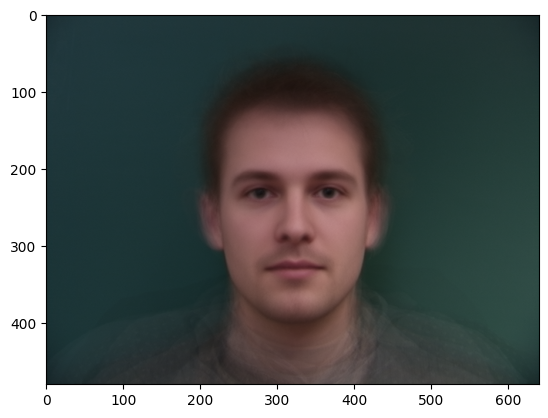

In [227]:
import csv
# n-1m.jpg
count = 1
def read_asf(fn):
    rows = []
    with open(fn) as f:
        reader = csv.reader(f, delimiter='\t')
        for row in reader:
            row = [e.strip() for e in row]
            if row and len(row) > 1 and row[0] != '#' and all(e.replace('.', '', 1).isdigit() for e in row):
                rows.append([float(row[2]), float(row[3]), int(row[4]), int(row[5]), int(row[6])])
    assert len(rows) == 58
    return rows
rows = read_asf(f'01-1m.asf')
# print(*rows, sep='\n')

def pts_from_row(rows, im):
    pts = np.array([np.array([int(e[0] * im.shape[1]), int(e[1] * im.shape[0])]) for e in rows] +
                   [np.array(p) for p in [(0, 0), (0, im.shape[0]), (im.shape[1], 0), (im.shape[1], im.shape[0])]])
    return pts
# pts = np.array([np.array([int(e[0] * imSum.shape[1]), int(e[1] * imSum.shape[0])]) for e in rows])
# plt.plot(pts[:, 0], pts[:, 1], 'rx')

imSum = sk.io.imread(f'01-1m.jpg')/255.
faceClouds = []
for i in range(2, 41):
    try:
        # imSum += sk.io.imread(f'{i:02d}-2m.jpg')/255.
        rows = read_asf(f'{i:02d}-1m.asf')
        faceClouds.append(pts_from_row(rows, imSum))
    except Exception as e:
        pass
    #     imSum += sk.io.imread(f'{i:02d}-1f.jpg')/255.

faceClouds = np.array(faceClouds)
print(faceClouds.shape)
danes_pts_mean = faceClouds.mean(axis=0)
# plt.plot(pts_mean[:, 0], pts_mean[:, 1], 'rx')

danes_pts_mean_dln = Delaunay(danes_pts_mean)
faces_morphed_to_mean = []

faces = []

for i in range(2, 41):
    try:
        im = sk.io.imread(f'{i:02d}-1m.jpg')/255.
        cloud = pts_from_row(read_asf(f'{i:02d}-1m.asf'), im)
        morphed = morphedIm(im, cloud, danes_pts_mean, danes_pts_mean_dln)
        faces_morphed_to_mean.append(morphed)
        faces.append(im)
    except Exception as e:
        pass

morphed_faces = np.array(faces_morphed_to_mean)
plt.imshow(faces_morphed_to_mean[10])
mean_face = morphed_faces.mean(axis=0)
plt.imshow(mean_face)


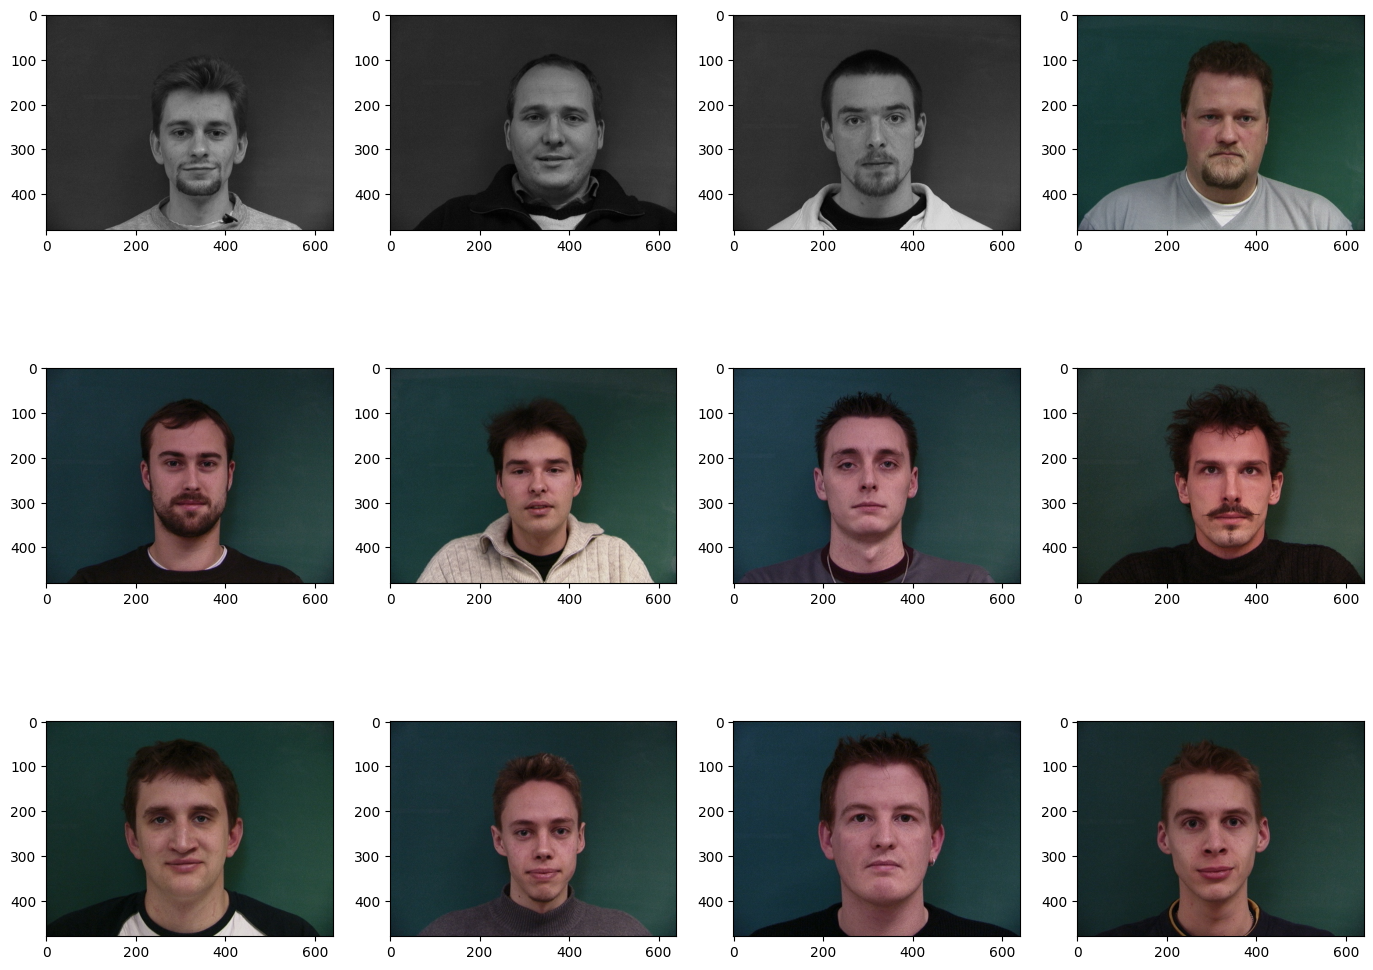

In [232]:
f = plt.figure(figsize=(17, 13))

for i in range(12):
    ax = f.add_subplot(3, 4, i + 1)
    plt.imshow(faces[i])
    

In [180]:
from sklearn.decomposition import PCA

print(morphed_faces.shape)
# rgb2grey_vec = np.array([0.2126, 0.7152, 0.0722])
# morphed_faces = np.einsum('nhwc,c->nhw', morphed_faces, rgb2grey_vec)

pcas = []
for ch in range(0, 3):
    pca = PCA()
    faces = morphed_faces[..., ch].reshape(32, -1)
    print(faces.shape)
    pca.fit(faces)
    pcas.append(pca)

(32, 480, 640, 3)
(32, 307200)
(32, 307200)
(32, 307200)


In [181]:
f = plt.figure(figsize=(24, 25))
_Ncol = 4
_Nrow = 8
_i: int = 0
def subplot():
    global _i
    _i = _i+1
    f.add_subplot(_Nrow, _Ncol, _i)

def imshow(im, **kwargs):
    subplot()
    graph_tri(danes_pts_mean, danes_pts_mean_dln)
    plt.imshow(im, **kwargs)


# plt.plot(pcas[0].singular_values_)

# for i in range(30):
#     im = reconstruct_component(pcas, i)
#     # print(im[5, 10, :])
#     imshow(im[:, :, 0], cmap='gray')

def graph_tri2(pts, dln):
    plt.triplot(pts[:, 0], pts[:, 1], dln.simplices)
    plt.plot(pts[:, 0], pts[:, 1], 'rx')
    for i, pt in enumerate(pts):
        plt.gca().annotate(str(i), (pt[0], pt[1]), fontsize=15, color='r')
        
# graph_tri2(danes_pts_mean, danes_pts_mean_dln)
# plt.imsave('mean_face_numbered.png', mean_face)

# imshow(mean_face + reconstruct_component(pcas, 4) * 10)
# imshow(mean_face + reconstruct_component(pcas, 4) * 100)

# plt.imshow(pcas[1].components_[5].reshape(morphed_faces.shape[1:3]))

# f = np.ones((5, 5))
# d = np.diag([2, 3, 4, 5, 6])
# print(f @ d)
# print(d @ f)

<Figure size 2400x2500 with 0 Axes>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04564040195722823..1.0941181786457486].


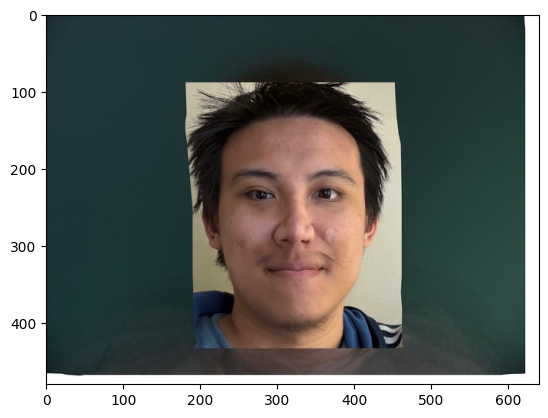

In [182]:
me_cloud, me, _, _ = import_pairs('avg_pop_face_compat_lduong_avg_pop_face.json')
me_dln = Delaunay(me_cloud)
# print(minimizer)
# me = plt.imread(f'avg_pop_face_compat_lduong.jpg')/255.
# graph_tri2(me_cloud, danes_pts_mean_dln)
me2avg = morphedIm(me, me_cloud, danes_pts_mean, danes_pts_mean_dln)
plt.imshow(me2avg)

avg2me = morphedIm(mean_face, danes_pts_mean, me_cloud, me_dln)
# plt.imshow(avg2me)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.02496805647300759..1.0040432258371463].


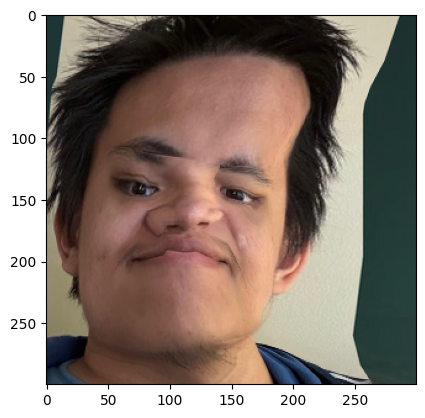

In [211]:
## Let's perform PCA on face shape instead

pcaFS = PCA(n_components=10)
pcaFS.fit(faceClouds.reshape(32, -1))

def car(im, cloud, pca, alpha):
    reducedCloud = pca.transform(cloud.reshape(1, -1)) * alpha
    reconstructedCloud = pca.inverse_transform(reducedCloud).reshape(cloud.shape)
    # plt.plot(reconstructedCloud[:, 0], reconstructedCloud[:, 1], 'rx')
    # plt.plot(pcaFS.singular_values_)
    car = morphedIm(im, cloud, reconstructedCloud, Delaunay(reconstructedCloud))
    return car

me_car = car(me, me_cloud, pcaFS, np.array([10, 2, 5, 5, 2, 2, 2, 2, 2, 2]))
plt.imshow(me_car[100:400, 150:450])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.029442039289875405..0.9077367084764842].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0259184032359507..0.9170383007751025].


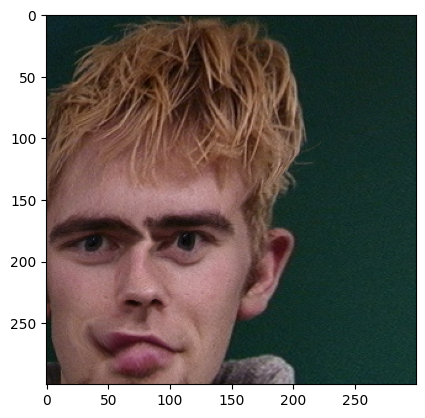

In [226]:
john = plt.imread(f'01-1m.jpg')/255.
john_cloud = pts_from_row(read_asf(f'01-1m.asf'), john)
john2avg = morphedIm(john, john_cloud, danes_pts_mean, danes_pts_mean_dln)
plt.imshow(john2avg)

john_car = car(john, john_cloud, pcaFS, np.array([10, 2, 5, 5, 2, 2, 2, 2, 2, 2]))
plt.imshow(john_car[100:400, 150:450])